In [29]:
# ==============================================================================
# 1. 라이브러리 임포트
# ==============================================================================
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm # 로컬에서는 tqdm.notebook 대신 일반 tqdm 사용
import joblib

# skimage
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.filters import gaussian
from skimage.restoration import denoise_bilateral
from skimage.util import img_as_ubyte
from skimage.feature import local_binary_pattern, hog
from skimage.transform import resize
from scipy import ndimage

# sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier # 사용하지는 않지만 임포트 유지
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances

# joblib (병렬 처리를 위해)
from joblib import Parallel, delayed

# faiss (KNN 가속화를 위해)
import faiss
print("✔ 모든 라이브러리 임포트 완료!")

✔ 모든 라이브러리 임포트 완료!


In [30]:
# ==============================================================================
# 2. 데이터 로딩 및 준비
# ==============================================================================

DATASET_BASE_PATH = "C:/Users/bvb09/.cache/kagglehub/datasets/mikhailma/test-dataset/versions/1/"

# 이미지 로드 함수
def load_images_from_folder(base_path, img_size=(120, 120)):
    images = []
    labels = []
    # 데이터셋 구조: Google_Recaptcha_V2_Images_Dataset/images/<label>/<image>.jpg
    image_folder_path = os.path.join(base_path, 'Google_Recaptcha_V2_Images_Dataset', 'images')
    
    if not os.path.exists(image_folder_path):
        raise FileNotFoundError(f"이미지 폴더를 찾을 수 없습니다: {image_folder_path}\n"
                                f"DATASET_BASE_PATH를 올바르게 설정했는지 확인해주세요.")

    for label_name in tqdm(os.listdir(image_folder_path), desc="Loading folders"):
        label_path = os.path.join(image_folder_path, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(label_name)
                    else:
                        print(f"경고: {img_path} 이미지를 로드할 수 없습니다.")
                except Exception as e:
                    print(f"경고: {img_path} 로딩 중 오류 발생 - {e}")
    return pd.DataFrame({'image_data': images, 'label': labels})

print("▶ 이미지 데이터 로드 중...")
try:
    images_df = load_images_from_folder(DATASET_BASE_PATH)
    print(f"✔ 총 {len(images_df)}개의 이미지 로드 완료.")
except FileNotFoundError as e:
    print(f"오류: {e}")
    print("데이터셋 경로를 올바르게 설정했는지 확인해주세요.")
    # 프로그램 종료 또는 추가 처리
    exit() # 스크립트 실행을 중단하려면 이 줄의 주석을 해제하세요.


# 라벨 인코딩
le = LabelEncoder()
images_df['label_encoded'] = le.fit_transform(images_df['label'])
print(f"✔ 라벨 인코딩 완료. 클래스: {le.classes_}")

# 층화 K-Fold 분할 준비
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("✔ Stratified K-Fold 설정 완료 (5-Fold).")


▶ 이미지 데이터 로드 중...


Loading folders: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]

✔ 총 11730개의 이미지 로드 완료.
✔ 라벨 인코딩 완료. 클래스: ['Bicycle' 'Bridge' 'Bus' 'Car' 'Chimney' 'Crosswalk' 'Hydrant'
 'Motorcycle' 'Other' 'Palm' 'Stair' 'Traffic Light']
✔ Stratified K-Fold 설정 완료 (5-Fold).


In [31]:
# ==============================================================================
# 3. 이미지 전처리 함수 (Colab 버전과 동일)
# ==============================================================================

# 대비 스트레칭
def contrast_stretch(img, p_low=2, p_high=98):
    low, high = np.percentile(img, (p_low, p_high))
    return rescale_intensity(img, in_range=(low, high))

# 그레이스케일 변환
def to_grayscale(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

# 히스토그램 평활화
def histogram_equalization(image_gray):
    return equalize_hist(image_gray)

# 노이즈 필터링
def remove_noise(image):
    image = gaussian(image, sigma=1)
    denoised_image = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, channel_axis=None)
    return img_as_ubyte(denoised_image)

# 엣지 검출 (Canny)
def edge_detection(image_gray, low_threshold=50, high_threshold=150, aperture_size=3):
    if image_gray.dtype != np.uint8:
        image_gray = cv2.convertScaleAbs(image_gray)
    return cv2.Canny(image_gray, low_threshold, high_threshold, apertureSize=aperture_size)

# 선명화
def sharpen_image(image_gray, low_threshold=50, high_threshold=150, amount=1.0):
    edges = cv2.Canny(image_gray, low_threshold, high_threshold)
    mask = (edges / 255.0).astype(np.float32)
    sharpened = image_gray.astype(np.float32) + amount * (mask * 255.0)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

# 전처리 함수
def preprocess_image(img, sigma=1.0):
    img = contrast_stretch(img)
    img = to_grayscale(img)
    img = histogram_equalization(img)
    img = remove_noise(img)
    img = edge_detection(img)
    img = sharpen_image(img)
    return img
print("✔ 이미지 전처리 함수 정의 완료.")

✔ 이미지 전처리 함수 정의 완료.


In [32]:
# ==============================================================================
# 4. 특징 추출 함수 (Colab 버전과 동일)
# ==============================================================================

# LBP (Local Binary Pattern)
def extract_lbp_features(image_gray, num_points=24, radius=3):
    lbp = local_binary_pattern(image_gray, num_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# HOG (Histogram of Oriented Gradients)
def extract_hog_descriptors(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(float) / 255.0
    features, _ = hog(image_gray, orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      transform_sqrt=True,
                      block_norm="L2-Hys",
                      visualize=True)
    return features

# SIFT (Scale-Invariant Feature Transform)
def extract_sift_descriptors(image_gray):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image_gray, None)
    if descriptors is None:
        return np.zeros(128)
    return np.mean(descriptors, axis=0) if descriptors.shape[0] > 0 else np.zeros(128)

# Laws' Texture Energy
def extract_laws_energy_features(image_gray, window_size=15):
    L5 = np.array([1, 4, 6, 4, 1], dtype=np.float32)
    E5 = np.array([-1, -2, 0, 2, 1], dtype=np.float32)
    S5 = np.array([-1, 0, 2, 0, -1], dtype=np.float32)
    W5 = np.array([-1, 2, 0, -2, 1], dtype=np.float32)
    R5 = np.array([1, -4, 6, -4, 1], dtype=np.float32)
    kernels = [L5, E5, S5, W5, R5]

    energy_features = []
    if image_gray.dtype == np.uint8:
        image_gray = image_gray.astype(np.float32)

    for k1 in kernels:
        for k2 in kernels:
            kernel = np.outer(k1, k2)
            filtered = ndimage.convolve(image_gray, kernel, mode='reflect')
            energy = np.abs(filtered)
            summed = cv2.boxFilter(energy, ddepth=-1, ksize=(window_size, window_size), normalize=False)
            energy_features.append(summed.mean())

    return np.array(energy_features, dtype=np.float32)

# 모든 특징을 결합하는 함수
def extract_features(image):
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    lbp_feat = extract_lbp_features(image_gray)
    hog_feat = extract_hog_descriptors(image_gray)
    sift_feat = extract_sift_descriptors(image_gray)
    laws_feat = extract_laws_energy_features(image_gray)

    lbp_feat = lbp_feat / (np.sum(lbp_feat) + 1e-7)
    hog_feat = hog_feat / (np.linalg.norm(hog_feat) + 1e-7)
    sift_feat = sift_feat / (np.linalg.norm(sift_feat) + 1e-7)
    laws_feat = laws_feat / (np.linalg.norm(laws_feat) + 1e-7)

    combined_features = np.concatenate([lbp_feat, hog_feat, sift_feat, laws_feat])
    normalized_features = combined_features / (np.linalg.norm(combined_features) + 1e-7)
    return normalized_features
print("✔ 특징 추출 함수 정의 완료.")

✔ 특징 추출 함수 정의 완료.


In [33]:
# ==============================================================================
# 5. 분류 모델 및 학습/평가 함수 (Faiss 적용, Colab 버전과 동일)
# ==============================================================================

# Faiss 기반 KNN 분류기 학습
def train_faiss_knn_classifier(X_train, y_train, n_neighbors=5):
    X_train = X_train.astype(np.float32)
    D = X_train.shape[1]
    index = faiss.IndexFlatL2(D)
    
    # 로컬 환경에서는 GPU 자원을 직접 확인하지 않으므로, 이 부분은 제거
    # Faiss-cpu만 사용하므로 GPU 관련 코드는 주석 처리 또는 제거
    # if faiss.get_num_gpus() > 0:
    #     res = faiss.StandardGpuResources()
    #     index = faiss.index_cpu_to_gpu(res, 0, index)

    index.add(X_train)
    return index, y_train, n_neighbors

# Faiss 기반 KNN 예측
def predict_faiss_knn(index, y_train_labels, n_neighbors, X_test):
    X_test = X_test.astype(np.float32)
    distances, indices = index.search(X_test, n_neighbors)

    y_pred = []
    for i in range(len(X_test)):
        neighbor_labels = y_train_labels[indices[i]]
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        predicted_label = unique_labels[np.argmax(counts)]
        y_pred.append(predicted_label)
    return np.array(y_pred)

# test() 함수
def test(model_tuple, X_test, y_test, average='weighted'):
    faiss_index, y_train_labels, n_neighbors = model_tuple
    
    print(f"  ▶ KNN 예측 중 (Faiss 사용, k={n_neighbors})...")
    y_pred = predict_faiss_knn(faiss_index, y_train_labels, n_neighbors, X_test)
    print("  ✔ 예측 완료.")

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_test, y_pred, average=average, zero_division=0)
    print(f"[Test Accuracy] {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    return y_pred
print("✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).")

✔ 분류 모델 및 학습/평가 함수 정의 완료 (Faiss 적용).


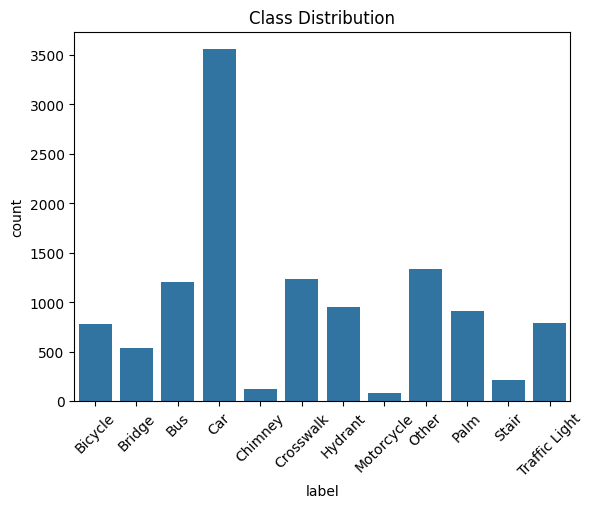

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=images_df)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

In [34]:
# ==============================================================================
# 6. 5-Fold 교차 검증 루프 및 모델 저장
# ==============================================================================
accuracies = []
precisions = []
recalls = []

# 모델 저장 경로 설정 (사용자 로컬 PC 내)
# 현재 스크립트가 실행되는 폴더 내에 'image_classification_models' 폴더 생성
MODEL_SAVE_BASE_DIR = 'image_classification_models'
os.makedirs(MODEL_SAVE_BASE_DIR, exist_ok=True)
print(f"모델 저장 기본 경로: {os.path.abspath(MODEL_SAVE_BASE_DIR)}")


print("\n=== 5-Fold 교차 검증 시작 ===")
for i, (train_index, test_index) in tqdm(enumerate(skf.split(images_df, images_df['label_encoded'])), total=skf.get_n_splits(), desc="Processing Folds"):
    f = {
        'fold': i,
        'X_train': images_df.iloc[train_index]['image_data'].values,
        'y_train': images_df.iloc[train_index]['label_encoded'].values,
        'X_test': images_df.iloc[test_index]['image_data'].values,
        'y_test': images_df.iloc[test_index]['label_encoded'].values,
    }
    print(f"\n=== Fold {f['fold']} ===")
    print(f"[Fold {f['fold']}] ▶ Train: {len(f['X_train'])}개, Test: {len(f['X_test'])}개")

    # 1) train set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Train feature extraction (Fold {f['fold']})...")
    X_train_feats = Parallel(n_jobs=-1)( # n_jobs=-1로 모든 CPU 코어 사용
        delayed(lambda img: extract_features(preprocess_image(img)))(img)
        for img in tqdm(f['X_test'], desc=f"  Extracting Test Features (Fold {f['fold']})", ascii=True, dynamic_ncols=True)
    )
    X_train_feats = np.array(X_train_feats)
    print(f"  ✔ Train feature extraction complete for Fold {f['fold']}. Feature Shape: {X_train_feats.shape}")
    
    # Faiss KNN 모델 학습 (Index 생성)
    faiss_model_tuple = train_faiss_knn_classifier(
        X_train_feats,
        f['y_train'],
        n_neighbors=5
    )
    print(f"  ✔ Faiss KNN 모델 학습 완료 (Fold {f['fold']}).")

    # 2) test set에서 feature 추출 (병렬 처리 적용)
    print(f"  ▶ Test feature extraction (Fold {f['fold']})...")
    X_test_feats = Parallel(n_jobs=-1)( # n_jobs=-1로 모든 CPU 코어 사용
        delayed(lambda img: extract_features(preprocess_image(img)))(img)
        for img in tqdm(f['X_test'], desc=f"  Extracting Test Features (Fold {f['fold']})")
    )
    X_test_feats = np.array(X_test_feats)
    print(f"  ✔ Test feature extraction complete for Fold {f['fold']}. Feature Shape: {X_test_feats.shape}")
    
    # 평가
    y_pred = test(
        faiss_model_tuple,
        X_test_feats,
        f['y_test'],
        average='weighted'
    )

    # 폴드별 지표 저장
    acc = accuracy_score(f['y_test'], y_pred)
    prec = precision_score(f['y_test'], y_pred, average='weighted', zero_division=0)
    rec  = recall_score(f['y_test'], y_pred, average='weighted', zero_division=0)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    
    # --- 각 폴드별 Faiss 모델 저장 ---
    fold_model_dir = os.path.join(MODEL_SAVE_BASE_DIR, 'knn_faiss_folds')
    os.makedirs(fold_model_dir, exist_ok=True)
    fold_index_path = os.path.join(fold_model_dir, f'faiss_index_fold_{f["fold"]}.bin')
    
    faiss.write_index(faiss_model_tuple[0], fold_index_path) # faiss_model_tuple[0]은 Faiss 인덱스
    joblib.dump(
        {'y_train_labels': faiss_model_tuple[1], 'n_neighbors': faiss_model_tuple[2]},
        os.path.join(fold_model_dir, f'faiss_params_fold_{f["fold"]}.joblib')
    )
    print(f"✔ Fold {f['fold']} Faiss 인덱스 및 파라미터가 '{fold_model_dir}'에 저장되었습니다.")
    # --- 저장 부분 끝 ---


# 5) 5-fold 평균 지표 출력
print("\n=== 5-Fold CV Average ===")
print(f"Accuracy : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall   : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")

모델 저장 기본 경로: c:\Users\bvb09\OneDrive\바탕 화면\컴퓨터비전\my\vision_challenge\image_classification_models

=== 5-Fold 교차 검증 시작 ===


Processing Folds:   0%|          | 0/5 [00:00<?, ?it/s]


=== Fold 0 ===
[Fold 0] ▶ Train: 9384개, Test: 2346개
  ▶ Train feature extraction (Fold 0)...








































































































































































































































































































  Extracting Test Features (Fold 0): 100%|##########| 2346/2346 [04:35<00:00,  8.51it/s]


  ✔ Train feature extraction complete for Fold 0. Feature Shape: (2346, 7235)
  ✔ Faiss KNN 모델 학습 완료 (Fold 0).
  ▶ Test feature extraction (Fold 0)...






































































































































































































































































































  Extracting Test Features (Fold 0): 100%|██████████| 2346/2346 [04:35<00:00,  8.51it/s]


  ✔ Test feature extraction complete for Fold 0. Feature Shape: (2346, 7235)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...


c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

  ✔ 예측 완료.
[Test Accuracy] 0.0776
               precision    recall  f1-score   support

      Bicycle       0.11      0.51      0.19       156
       Bridge       0.02      0.07      0.04       107
          Bus       0.06      0.29      0.10       242
          Car       0.14      0.03      0.05       711
      Chimney       0.00      0.00      0.00        25
    Crosswalk       0.00      0.00      0.00       248
      Hydrant       0.00      0.00      0.00       191
   Motorcycle       0.00      0.00      0.00        16
        Other       0.00      0.00      0.00       268
         Palm       0.00      0.00      0.00       182
        Stair       0.00      0.00      0.00        42
Traffic Light       0.00      0.00      0.00       158

     accuracy                           0.08      2346
    macro avg       0.03      0.08      0.03      2346
 weighted avg       0.06      0.08      0.04      2346

✔ Fold 0 Faiss 인덱스 및 파라미터가 'image_classification_models\knn_faiss_folds'에 저장되었습니다.






































































































































































































































































































  Extracting Test Features (Fold 1): 100%|##########| 2346/2346 [04:43<00:00,  8.28it/s]


  ✔ Train feature extraction complete for Fold 1. Feature Shape: (2346, 7235)
  ✔ Faiss KNN 모델 학습 완료 (Fold 1).
  ▶ Test feature extraction (Fold 1)...






































































































































































































































































































  Extracting Test Features (Fold 1): 100%|██████████| 2346/2346 [04:42<00:00,  8.31it/s]


  ✔ Test feature extraction complete for Fold 1. Feature Shape: (2346, 7235)
  ▶ KNN 예측 중 (Faiss 사용, k=5)...


c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bvb09\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

  ✔ 예측 완료.
[Test Accuracy] 0.0776
               precision    recall  f1-score   support

      Bicycle       0.13      0.54      0.21       156
       Bridge       0.03      0.13      0.05       107
          Bus       0.06      0.31      0.11       242
          Car       0.07      0.01      0.02       711
      Chimney       0.00      0.00      0.00        25
    Crosswalk       0.00      0.00      0.00       248
      Hydrant       0.00      0.00      0.00       190
   Motorcycle       0.00      0.00      0.00        17
        Other       0.00      0.00      0.00       268
         Palm       0.00      0.00      0.00       182
        Stair       0.00      0.00      0.00        42
Traffic Light       0.00      0.00      0.00       158

     accuracy                           0.08      2346
    macro avg       0.03      0.08      0.03      2346
 weighted avg       0.04      0.08      0.03      2346

✔ Fold 1 Faiss 인덱스 및 파라미터가 'image_classification_models\knn_faiss_folds'에 저장되었습니다.
























































Processing Folds:  40%|████      | 2/5 [19:49<29:44, 594.84s/it]


KeyboardInterrupt: 

In [ ]:
# ==============================================================================
# 7. 최종 모델 학습 및 저장 (전체 데이터셋)
# ==============================================================================
print("\n=== 최종 모델 학습 시작 (전체 데이터셋) ===")

# 전체 데이터셋에 대한 특징 추출 (이 과정도 Parallel 적용)
print("▶ 전체 데이터셋 특징 추출 중...")
X_full_feats = Parallel(n_jobs=-1)( # n_jobs=-1로 모든 CPU 코어 사용
    delayed(lambda img: extract_features(preprocess_image(img)))(img)
    for img in tqdm(images_df['image_data'].values, desc="Extracting Full Dataset Features")
)
X_full_feats = np.array(X_full_feats)
y_full_labels = images_df['label_encoded'].values
print(f"✔ 전체 데이터셋 특징 추출 완료. Feature Shape: {X_full_feats.shape}")

# 최종 Faiss KNN 모델 학습 (전체 데이터셋)
final_k_neighbors = 5 # 예시 값. CV 결과에 따라 조정 가능
final_faiss_index, _, _ = train_faiss_knn_classifier(
    X_full_feats,
    y_full_labels,
    n_neighbors=final_k_neighbors
)
print("✔ 최종 Faiss KNN 모델 학습 완료.")

# 최종 Faiss 모델 저장
final_model_dir = os.path.join(MODEL_SAVE_BASE_DIR, 'final_model')
os.makedirs(final_model_dir, exist_ok=True)

faiss.write_index(final_faiss_index, os.path.join(final_model_dir, 'final_faiss_index.bin'))
joblib.dump(
    {'y_train_labels': y_full_labels, 'n_neighbors': final_k_neighbors},
    os.path.join(final_model_dir, 'final_faiss_params.joblib')
)
print(f"✔ 최종 Faiss KNN 모델 및 파라미터가 '{final_model_dir}'에 저장되었습니다.")
print("\n=== 전체 프로세스 완료 ===")